# EnvisionBOX Summer School 2025, Day 4: Bringing all together
## Motion processing

In [35]:
# packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import matplotlib.pyplot as plt

curfolder = os.getcwd()

# folders with processed data
MTfolder = os.path.join(curfolder, 'pose-3d')

# prepare all files
mtfiles = glob.glob(os.path.join(MTfolder, '*.trc'))

# create folder for storing processed motion data
MTfolder_processed = os.path.join(curfolder, 'processedMotion')

if not os.path.exists(MTfolder_processed):
    os.makedirs(MTfolder_processed)



## Converting trc to csv

In [36]:
from trc import TRCData

framerate = 30

# Loop through files and convert to csv
for file in mtfiles:
    print(file)
    # There is a mistake in LSTM files formatting (those are output of marker augmentation), se we want to skip them
    if 'LSTM' not in file:
        mocap_data = TRCData()
        mocap_data.load(os.path.abspath(file))
        num_frames = mocap_data['NumFrames']
        markernames = mocap_data['Markers'] # the marker names are not

        # Convert mocap_data to pandas dataframe
        mocap_data_df = pd.DataFrame(mocap_data, columns=mocap_data['Markers'])
        # Each value within the dataframe consists a list of x,y,z coordinates, we want to seperate these out so that each marker and dimension has its own column
        colnames = []
        for marker in markernames:
            colnames.append(marker + '_x')
            colnames.append(marker + '_y')
            colnames.append(marker + '_z')

        # Create a new DataFrame to store separated values
        new_df = pd.DataFrame()

        # Iterate through each column in the original DataFrame
        for column in mocap_data_df.columns:
            # Extract the x, y, z values from each cell
            xyz = mocap_data_df[column].tolist()
            # Create a new DataFrame with the values in the cell separated into their own columns
            xyz_df = pd.DataFrame(xyz, columns=[column + '_x', column + '_y', column + '_z'])
            # Add the new columns to the new DataFrame
            new_df = pd.concat([new_df, xyz_df], axis=1)

        # Add a new time column to the new dataframe assuming the framerate was 60 fps
        time = []
        ts = 0
        for i in range(0, int(num_frames)):
            ts = ts + 1/framerate
            time.append(ts)

        # Add the time column to the new dataframe
        new_df['Time'] = time
        # Convert to ms
        new_df['Time'] = new_df['Time'] * 1000

        # create a 0time row with Time=0 and all other values set to values of first row
        zero_time_row = new_df.iloc[0].copy()
        zero_time_row['Time'] = 0
        # Append the zero time row in the beginning of the dataframe
        new_df = pd.concat([pd.DataFrame([zero_time_row]), new_df], ignore_index=True)


        # Add also file
        new_df['file'] = os.path.basename(file).split('.')[0]

        # Write pd dataframe to csv
        new_df.to_csv(file+'.csv', index=False)

    else:
        continue

c:\Users\Sarka Kadava\Documents\Github\envisionBOX_SummerschoolAmsterdam2025\Day4_MultimodalMerging\pose-3d\femalemonologue2_t3_0-619.trc


## Preprocessing

In [37]:
mtfiles = glob.glob(os.path.join(MTfolder, '*.csv'))

Let's plot to inspect

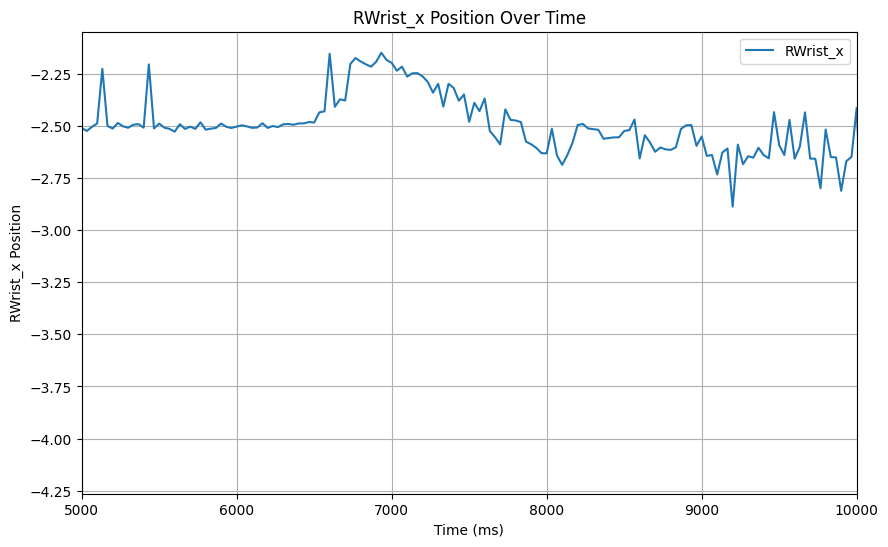

In [38]:
sample_file = mtfiles[0]
sample_df = pd.read_csv(sample_file)

plt.figure(figsize=(10, 6))
plt.plot(sample_df['Time'], sample_df['RWrist_x'], label='RWrist_x')
plt.xlabel('Time (ms)')
plt.ylabel('RWrist_x Position')
plt.title('RWrist_x Position Over Time')
plt.xlim(5000, 10000) # xlim from 5000 to 10000
plt.legend()
plt.grid()
plt.show()


### Smoothing

Looking at the plots, you may notice that the data is quite noisy and jerky. This is because we are collecting each value for a keypoint at certain frame rate - for us it is ca. 16 ms.

We can smooth the data with various filters - Butterworth, Savitzky-Golay, etc.

In this script, we will be using Savitzky-Golay filter. This filter fits a x-order polynomial to a sequence of data points and then evaluates the polynomial at the central point of the sequence. This is repeated for on sequence of windows. This allows us to smooth the data without losing the original shape of the curve.

When using this filter, we need to specify the window and order parameters. The window parameter specifies the number of data points used to fit the polynomial, while the order parameter specifies the order of the polynomial.

So now the question arises - HOW TO CHOOSE THOSE???

We are not going to blindly guess. We can just try different combinations and see which are smoothing the data approprietly, without losing too much of the original shape of the curve.

In [39]:
# function to check different smoothing windows and orders
def check_smooth_strength(df, windows, orders, keytoplot):

    # prepare new df
    df_smooth = pd.DataFrame()

    for win in windows:
        for ord in orders:
            df_smooth[keytoplot + '_savgol' + str(win) + '_' + str(ord)] = scipy.signal.savgol_filter(df[keytoplot], win, ord)

    # make R_Hand_x from df_sample a list
    keytoplot_unsmoothed = df[keytoplot].tolist()

    # load these values into df_smooth as a new column
    df_smooth[keytoplot] = keytoplot_unsmoothed

    # plot keytoplot in all strngths
    colstoplot = [x for x in df_smooth.columns if keytoplot in x]
    plt.figure()
    for col in colstoplot:
        plt.plot(df_smooth[col], label=col)
    plt.legend()
    plt.show()

Let's start with keypoint that is probably for us the most important - the wrist

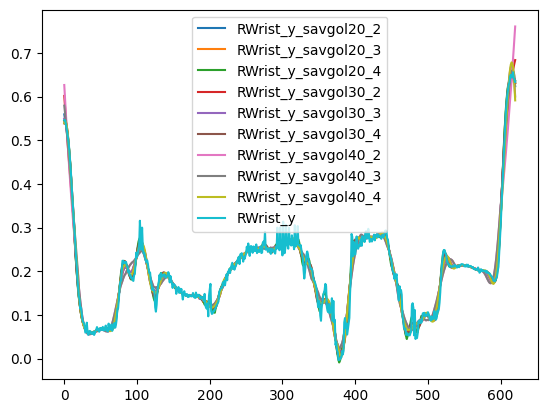

In [40]:
#| echo: false

windows = [20, 30, 40] # list possible window
orders = [2, 3, 4] # list possible orders

check_smooth_strength(sample_df, windows, orders, 'RWrist_y')

Can you comment on some of the different combinations?

It is usually also good idea to check other keypoints and whether they should be smoothed with the same parameters.

It is often the truth that leg keypoints are more jerky/noisy than arm keypoints, mainly because they are more 'occluded' than elbow or wrist - because of clothes.

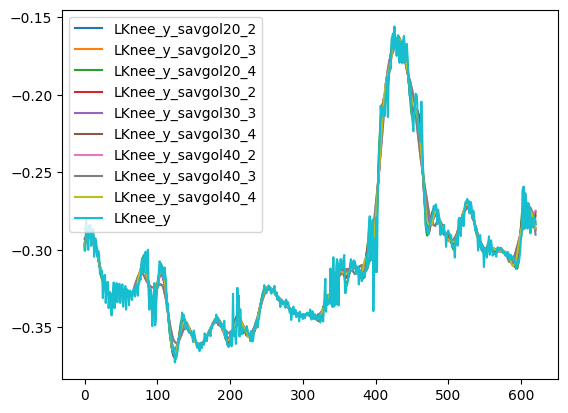

In [41]:
#| echo: false

windows = [20, 30, 40] # list possible window
orders = [2, 3, 4] # list possible orders

check_smooth_strength(sample_df, windows, orders, 'LKnee_y')

### Deriving

Most likely, we want for analysis something more than just coordinates.

Coordinates represent positional data. We can get more information from the data by calculating the derivatives. Derivatives represent the rate of change of a function at a given point.

First derivate of positional data represents the rate of change of the position. This means .... Second derivate of positional data represents the rate of change of the rate of change of the position. This means .... Third derivate of positional data represents the rate of change of the rate of change of the rate of change of the position. This means ....

Below, you can see functions that always have the same pipeline:

- collecting columns to be differentiated
- differentiating them
- smoothing the differentiated signal

Notice one thing in the code:
```python
speed = speed*sr
```
It seems that we are multiplying the speed by the sampling rate. Why?

In [42]:
#| code-fold: true
#| code-summary: Code with functions for processing kinematic data


# get kinematic derivatives
def get_derivatives(df, sr, upperbodycols, lowerbodycols):

    mtcols = df.columns
    # get rid of cols that are not x, y or z
    mtcols = [x for x in mtcols if '_x' in x or '_y' in x or '_z' in x]


    # prepare cols for speed
    cols = [x.split('_')[0] for x in mtcols]
    colsforspeed = list(set(cols))

    # for each unique colname (cols), calculate speed 
    for col in colsforspeed:
        # get x and y columns
        x = df[col + '_x']
        y = df[col + '_y']
        z = df[col + '_z'] # note that y and z are flipped
        
        # calculate speed
        speed = np.insert(np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2),0,0)
        
        # multiply the values by sr, why???
        speed = speed*sr

        # smooth
        speed = scipy.signal.savgol_filter(speed, 20, 3)

        # if the col contains wrist, we will alco calculate the vertical velocity (z dimension)
        if 'Wrist' in col:
            verticvel = np.insert(np.diff(z), 0, 0)
            verticvel = verticvel*sr
            verticvel = scipy.signal.savgol_filter(verticvel, 20, 3)

        # derive acceleration	
        acceleration = np.insert(np.diff(speed), 0, 0)
        acceleration = scipy.signal.savgol_filter(acceleration, 20, 3)

        # derive jerk
        jerk = np.insert(np.diff(acceleration), 0, 0)
        jerk = scipy.signal.savgol_filter(jerk, 20, 3)

        # new_data
        new_data = pd.DataFrame({col + '_speed': speed, col + '_acc': acceleration, col + '_jerk': jerk})
        df = pd.concat([df, new_data], axis=1)
   
    return df

What is the sampling rate in our data?

In [43]:
# what is our sr
sr = 1/np.mean(np.diff(sample_df['Time'])) # average time interval (difference) between consecutive frames
print(sr)

0.02999999999999973


In what unit the sr is?

In [44]:
print(sr*1000)

29.99999999999973


And now?

In [45]:
sr = sr

# Step 1: Smooth
colstosmooth = [x for x in sample_df.columns if 'Time' not in x and 'file' not in x]

for col in colstosmooth:
    sample_df[col] = scipy.signal.savgol_filter(sample_df[col], 20, 3)

# Step 2: Get derivatives
sample_df = get_derivatives(sample_df, sr, [], [])

In [46]:
sample_df.head()

,Hip_x,Hip_y,Hip_z,RHip_x,RHip_y,RHip_z,RKnee_x,RKnee_y,RKnee_z,RAnkle_x,...,RKnee_jerk,RBigToe_speed,RBigToe_acc,RBigToe_jerk,LAnkle_speed,LAnkle_acc,LAnkle_jerk,RElbow_speed,RElbow_acc,RElbow_jerk
0,-2.874114,0.128422,0.240529,-2.933375,0.102344,0.309413,-3.013285,-0.286603,0.308911,-3.054591,...,-1.030787e-07,0.000482,-0.000036,0.000002,0.000169,5.447885e-08,-0.000004,0.000089,0.000040,7.362293e-06
1,-2.877743,0.130540,0.241714,-2.933440,0.105694,0.310404,-3.008769,-0.283787,0.310738,-3.060498,...,-2.289812e-07,0.000427,-0.000030,0.000004,0.000161,-5.624400e-06,-0.000003,0.000172,0.000050,4.856319e-06
2,-2.880713,0.131461,0.242683,-2.933396,0.108066,0.311301,-3.004658,-0.281592,0.312405,-3.063713,...,-3.371918e-07,0.000386,-0.000024,0.000005,0.000152,-9.699176e-06,-0.000002,0.000247,0.000056,2.517804e-06
3,-2.883077,0.131293,0.243462,-2.933238,0.109527,0.312123,-3.000905,-0.279970,0.313928,-3.064548,...,-4.280732e-07,0.000357,-0.000019,0.000005,0.000141,-1.234746e-05,-0.000002,0.000314,0.000058,3.596581e-07
4,-2.884884,0.130145,0.244079,-2.932965,0.110145,0.312889,-2.997459,-0.278874,0.315325,-3.063318,...,-5.019885e-07,0.000338,-0.000014,0.000005,0.000129,-1.374688e-05,-0.000001,0.000373,0.000058,-1.605207e-06


You may ask - why do we smooth the positions, then derive, and then smooth again the derivatives? Wouldn't it be more efficient to first derive everything we want, and smooth the whole dataframe at once?

Let's try it then

In [47]:
sample_df_test = pd.read_csv(sample_file)

# Step 1: Derive
sample_df_test = get_derivatives(sample_df_test, sr, [], [])

# Step 2: Smooth
colstosmooth = [x for x in sample_df_test.columns if 'Time' not in x and 'file' not in x]

for col in colstosmooth:
    sample_df_test[col] = scipy.signal.savgol_filter(sample_df_test[col], 20, 3)

In [48]:
sample_df_test.head()

,Hip_x,Hip_y,Hip_z,RHip_x,RHip_y,RHip_z,RKnee_x,RKnee_y,RKnee_z,RAnkle_x,...,RKnee_jerk,RBigToe_speed,RBigToe_acc,RBigToe_jerk,LAnkle_speed,LAnkle_acc,LAnkle_jerk,RElbow_speed,RElbow_acc,RElbow_jerk
0,-2.874114,0.128422,0.240529,-2.933375,0.102344,0.309413,-3.013285,-0.286603,0.308911,-3.054591,...,5.262494e-06,-0.000674,0.001385,-0.000051,0.000163,0.000180,-0.000018,-0.000037,0.000107,0.000008
1,-2.877743,0.130540,0.241714,-2.933440,0.105694,0.310404,-3.008769,-0.283787,0.310738,-3.060498,...,3.697922e-06,0.001149,0.001117,-0.000121,0.000356,0.000140,-0.000021,0.000143,0.000111,0.000003
2,-2.880713,0.131461,0.242683,-2.933396,0.108066,0.311301,-3.004658,-0.281592,0.312405,-3.063713,...,2.262035e-06,0.002522,0.000869,-0.000169,0.000506,0.000106,-0.000023,0.000298,0.000111,-0.000002
3,-2.883077,0.131293,0.243462,-2.933238,0.109527,0.312123,-3.000905,-0.279970,0.313928,-3.064548,...,9.600598e-07,0.003492,0.000641,-0.000200,0.000616,0.000077,-0.000023,0.000428,0.000107,-0.000005
4,-2.884884,0.130145,0.244079,-2.932965,0.110145,0.312889,-2.997459,-0.278874,0.315325,-3.063318,...,-2.027788e-07,0.004104,0.000435,-0.000213,0.000691,0.000053,-0.000023,0.000537,0.000100,-0.000008


Now let's compare the results visually

These are positions (y dimension)

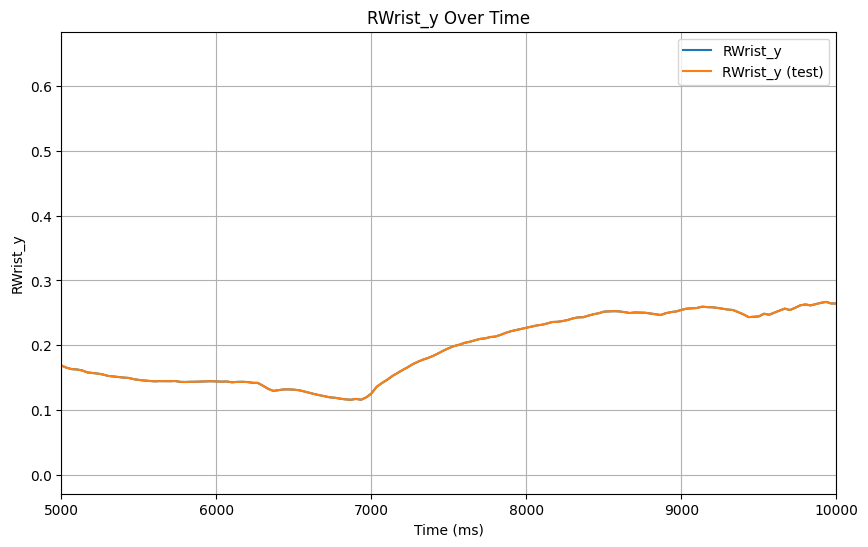

In [49]:
# plot RWrist_y
plt.figure(figsize=(10, 6))
plt.plot(sample_df['Time'], sample_df['RWrist_y'], label='RWrist_y')
plt.plot(sample_df_test['Time'], sample_df_test['RWrist_y'], label='RWrist_y (test)')
plt.xlabel('Time (ms)')
plt.ylabel('RWrist_y')
plt.title('RWrist_y Over Time')
plt.xlim(5000, 10000)  # xlim from 5000 to 10000
plt.legend()
plt.grid()
plt.show()

Now the speed

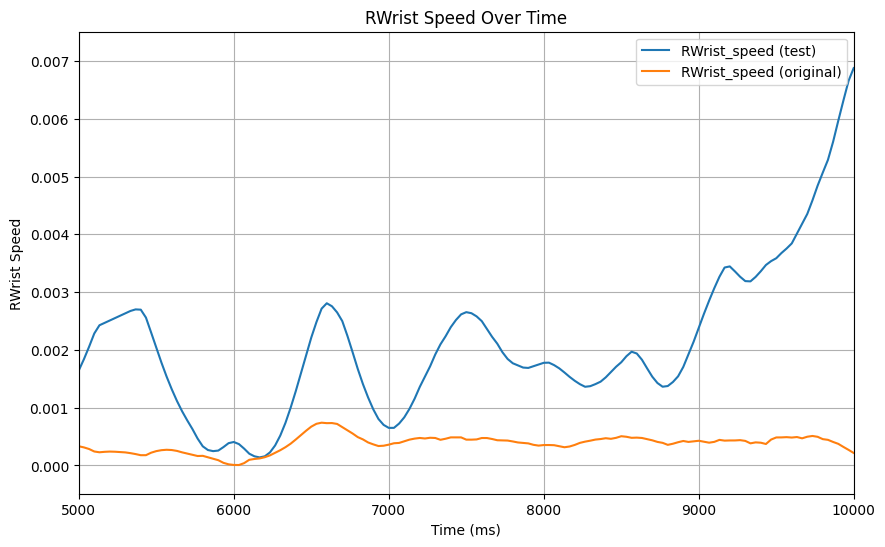

In [50]:
# plot speed of RWrist from sample_df_test and sample_df
plt.figure(figsize=(10, 6))
plt.plot(sample_df_test['Time'], sample_df_test['RWrist_speed'], label='RWrist_speed (test)')
plt.plot(sample_df['Time'], sample_df['RWrist_speed'], label='RWrist_speed (original)')
plt.xlabel('Time (ms)')
plt.ylabel('RWrist Speed')
plt.title('RWrist Speed Over Time')
plt.xlim(5000, 10000)  # xlim from 5000 to 10000
plt.legend()
plt.grid()
plt.show()

Now the acceleration

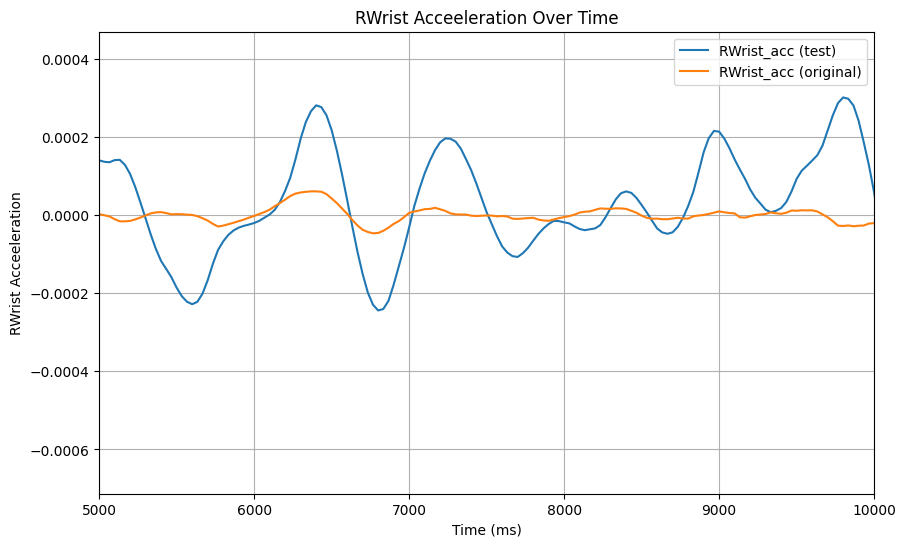

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(sample_df_test['Time'], sample_df_test['RWrist_acc'], label='RWrist_acc (test)')
plt.plot(sample_df['Time'], sample_df['RWrist_acc'], label='RWrist_acc (original)')
plt.xlabel('Time (ms)')
plt.ylabel('RWrist Acceeleration')
plt.title('RWrist Acceeleration Over Time')
plt.xlim(5000, 10000)  # xlim from 5000 to 10000
plt.legend()
plt.grid()
plt.show()

What do you see?

Yes, the order matters. Differentiating multiplies the noise present in a signal, so before **every** differentiation, we want to make sure our data are relatively clean.

So now we performed all steps that are necessary to get nice, clean data ready for analysis - on a single file. But we have more of them ready.

Luckily, because we have all the steps in functions, we can just apply them to all files in a loop.


## Full loop

In [52]:
#| code-fold: false
#| eval: false

# upper body cols
upperbodycols = ['Head', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'Nose', 'RIndex', 'LIndex']
# lower body cols
lowerbodycols = ['RHip', 'RKnee', 'RAnkle', 'RHeel' 'LHip', 'LKnee', 'LAnkle', 'LHeel']

for file in mtfiles:

    fileid = os.path.basename(file).split('.')[0]
    
    print('working on:' + fileid)

    # load it
    mt = pd.read_csv(file)

    # keep only cols of interest
    colstokeep = ["Time", "RHip", "RKnee", "RAnkle", "RHeel", "LHip", "LKnee", "LAnkle", "LHeel", "Neck", "Head", "Nose", "RShoulder", "RElbow", "RWrist", "RIndex", "LShoulder", "LElbow", "LWrist",
    "LIndex",
]
    mt = mt[[col for col in mt.columns if any(x in col for x in colstokeep)]]

    # flip y and z dimension as they are reversed from OpenPose/Pose2sim - DOUBLE CHECK

    # if col has _y in it, replace it by _temp
    mt.columns = [x.replace('_y', '_temp') for x in mt.columns]
    # replace _z by _y
    mt.columns = [x.replace('_z', '_y') for x in mt.columns]
    # replace _temp by _z
    mt.columns = [x.replace('_temp', '_z') for x in mt.columns]

    ####### SMOOTHING ######

    # smooth all columns except time with savgol
    mtcols = mt.columns
    colstosmooth = [mtcol for mtcol in mtcols if 'Time' not in mtcol and 'file' not in mtcol]

    mt_smooth = pd.DataFrame()

    for col in colstosmooth:
        mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 20, 3)
        # alternatively, it is possible to smooth lower and upper body with differently strong filter - we do not use it here though, as 20,3 filter seems to work well
        # # if the col belongs to upperbody, smooth with 15,1
        # if any(x in col for x in upperbodycols):
        #     mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 15, 1)
        # # as the lowerbody keypoints are not moving that much, they are much more prone to noise (e.g., from the measurement error of OpenPose, therefore we will smooth them with a little higher window)
        # elif any(x in col for x in lowerbodycols):
        #     mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 20, 1)
        # else:
        #     mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 15, 1)

        # and put them all to cms
        mt_smooth[col] = mt_smooth[col]*100

    # add back time column
    mt_smooth['Time'] = mt['Time']

    # get sampling rate
    sr = 1/np.mean(np.diff(mt['Time']))

    ###### DERIVATIVES ######

    # get kinematic derivatives
    mt_smooth = get_derivatives(mt_smooth, sr, upperbodycols, lowerbodycols)


    # add trialid
    mt_smooth['file'] = fileid

    # write to csv
    mt_smooth.to_csv(MTfolder_processed + '/mt_' + fileid + '.csv', index=False)

working on:femalemonologue2_t3_0-619
